In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
import sys

In [3]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3) 
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss 
            + object_loss  
            + self.lambda_noobj * no_object_loss 
            + class_loss  
        )

        return loss

In [4]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [5]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [6]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [7]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [8]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [9]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
   
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [10]:
def plot_image(image, boxes):
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    for box in boxes:
        box = box[2:]
        assert len(box) == 4
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.show()


In [11]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [12]:
def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [13]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [14]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [15]:
seed = 123
torch.manual_seed(seed)
 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "/kaggle/input/pascalvoc-yolo/images"
LABEL_DIR = "/kaggle/input/pascalvoc-yolo/labels"

In [16]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [17]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [18]:
precision = []
mean_loss = []
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

train_dataset = VOCDataset(
        "/kaggle/input/pascalvoc-yolo/100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

test_dataset = VOCDataset(
        "/kaggle/input/pascalvoc-yolo/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

for epoch in range(EPOCHS):
    pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

    mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
    precision.append(mean_avg_prec)
    if (epoch+1)%50==0:
        msg = f'Finished epoch {epoch+1}/{EPOCHS}'
        sys.stdout.write('\r' + msg)
    train_fn(train_loader, model, optimizer, loss_fn)

100%|██████████| 6/6 [00:03<00:00,  1.78it/s, loss=1e+3]   

Mean loss was 965.1165568033854



100%|██████████| 6/6 [00:02<00:00,  2.78it/s, loss=433]

Mean loss was 564.5178527832031



100%|██████████| 6/6 [00:02<00:00,  2.77it/s, loss=539]

Mean loss was 452.5281575520833



100%|██████████| 6/6 [00:02<00:00,  2.81it/s, loss=451]

Mean loss was 401.60321553548175



100%|██████████| 6/6 [00:02<00:00,  2.75it/s, loss=389]

Mean loss was 330.910639444987



100%|██████████| 6/6 [00:02<00:00,  2.75it/s, loss=177]

Mean loss was 291.22642517089844



100%|██████████| 6/6 [00:02<00:00,  2.77it/s, loss=196]

Mean loss was 249.4464569091797



100%|██████████| 6/6 [00:02<00:00,  2.75it/s, loss=219]

Mean loss was 214.16324361165366



100%|██████████| 6/6 [00:02<00:00,  2.73it/s, loss=231]

Mean loss was 192.06912994384766



100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=136]

Mean loss was 178.80653127034506



100%|██████████| 6/6 [00:02<00:00,  2.76it/s, loss=127]

Mean loss was 169.72232055664062



100%|██████████| 6/6 [00:02<00:00,  2.75it/s, loss=189]

Mean loss was 157.9963722229004



100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=165] 

Mean loss was 140.69126510620117



100%|██████████| 6/6 [00:02<00:00,  2.73it/s, loss=119]

Mean loss was 133.5591583251953



100%|██████████| 6/6 [00:02<00:00,  2.71it/s, loss=126]

Mean loss was 118.4466183980306



100%|██████████| 6/6 [00:02<00:00,  2.73it/s, loss=118] 

Mean loss was 100.6466178894043



100%|██████████| 6/6 [00:02<00:00,  2.73it/s, loss=86.8]

Mean loss was 93.02864201863606



100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=116] 

Mean loss was 93.3994369506836



100%|██████████| 6/6 [00:02<00:00,  2.73it/s, loss=97.9]

Mean loss was 87.45266087849934



100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=53.5]

Mean loss was 76.08114306131999



100%|██████████| 6/6 [00:02<00:00,  2.70it/s, loss=79]  

Mean loss was 79.25607935587566



100%|██████████| 6/6 [00:02<00:00,  2.74it/s, loss=93.7]

Mean loss was 75.93733596801758



100%|██████████| 6/6 [00:02<00:00,  2.71it/s, loss=76.6]

Mean loss was 72.07465744018555



100%|██████████| 6/6 [00:02<00:00,  2.71it/s, loss=61.8]

Mean loss was 67.40200614929199



100%|██████████| 6/6 [00:02<00:00,  2.70it/s, loss=64.1]

Mean loss was 65.34527079264323



100%|██████████| 6/6 [00:02<00:00,  2.65it/s, loss=75.4]

Mean loss was 60.44249407450358



100%|██████████| 6/6 [00:02<00:00,  2.68it/s, loss=89.2]

Mean loss was 64.38567733764648



100%|██████████| 6/6 [00:02<00:00,  2.71it/s, loss=80.7]

Mean loss was 66.71055221557617



100%|██████████| 6/6 [00:02<00:00,  2.66it/s, loss=49.9]

Mean loss was 55.720709482828774



100%|██████████| 6/6 [00:02<00:00,  2.70it/s, loss=81.1]

Mean loss was 55.79296366373698



100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=48.1]

Mean loss was 56.79842885335287



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=50.6]

Mean loss was 51.584738413492836



100%|██████████| 6/6 [00:02<00:00,  2.65it/s, loss=60.3]

Mean loss was 52.450567881266274



100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=69.8]

Mean loss was 55.83593304951986



100%|██████████| 6/6 [00:02<00:00,  2.65it/s, loss=47.7]

Mean loss was 52.08455276489258



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=60.1]

Mean loss was 48.87855593363444



100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=27.7]

Mean loss was 48.5146598815918



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=33.3]

Mean loss was 41.81291071573893



100%|██████████| 6/6 [00:02<00:00,  2.66it/s, loss=58.5]

Mean loss was 40.8147300084432



100%|██████████| 6/6 [00:02<00:00,  2.67it/s, loss=41.3]

Mean loss was 41.73074531555176



100%|██████████| 6/6 [00:02<00:00,  2.66it/s, loss=72.1]

Mean loss was 49.64772351582845



100%|██████████| 6/6 [00:02<00:00,  2.64it/s, loss=47]  

Mean loss was 46.658803939819336



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=37.3]

Mean loss was 39.452402432759605



100%|██████████| 6/6 [00:02<00:00,  2.66it/s, loss=52.9]

Mean loss was 46.61129379272461



100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=55.1]

Mean loss was 41.44900385538737



100%|██████████| 6/6 [00:02<00:00,  2.64it/s, loss=36.8]

Mean loss was 37.663490295410156



100%|██████████| 6/6 [00:02<00:00,  2.67it/s, loss=37.5]

Mean loss was 38.583047231038414



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=35.1]

Mean loss was 42.84671878814697



100%|██████████| 6/6 [00:02<00:00,  2.65it/s, loss=48.8]

Mean loss was 36.631916999816895


Finished epoch 50/1000

100%|██████████| 6/6 [00:02<00:00,  2.65it/s, loss=43.8]

Mean loss was 36.74820041656494



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=24.4]

Mean loss was 38.95207913716634



100%|██████████| 6/6 [00:02<00:00,  2.67it/s, loss=28.2]

Mean loss was 35.07103983561198



100%|██████████| 6/6 [00:02<00:00,  2.66it/s, loss=40.7]

Mean loss was 32.589555740356445



100%|██████████| 6/6 [00:02<00:00,  2.64it/s, loss=27.5]

Mean loss was 33.62721602121989



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=49.3]

Mean loss was 32.79953638712565



100%|██████████| 6/6 [00:02<00:00,  2.66it/s, loss=29.7]

Mean loss was 33.378360430399574



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=27.5]

Mean loss was 32.1948439280192



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=35.9]

Mean loss was 33.719847997029625



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=26.4]

Mean loss was 36.563719749450684



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=23.5]

Mean loss was 33.02044169108073



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=37.4]

Mean loss was 32.167848904927574



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=21.2]

Mean loss was 31.286182085673016



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=45.4]

Mean loss was 32.94027932484945



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=59.7]

Mean loss was 35.59614912668864



100%|██████████| 6/6 [00:02<00:00,  2.65it/s, loss=46]  

Mean loss was 31.34081204732259



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=21.9]

Mean loss was 26.343719164530437



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=28.1]

Mean loss was 26.573215166727703



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=25.4]

Mean loss was 25.186560312906902



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=27.5]

Mean loss was 27.997581481933594



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=20.1]

Mean loss was 29.837076505025227



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=28.3]

Mean loss was 28.046792030334473



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=23.8]

Mean loss was 27.282659848531086



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=28.7]

Mean loss was 24.77084795633952



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=25.7]

Mean loss was 25.07121213277181



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=25.3]

Mean loss was 27.301424344380695



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=17.2]

Mean loss was 25.72061252593994



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=30.6]

Mean loss was 26.64461358388265



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=23.6]

Mean loss was 27.94707139333089



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=39.7]

Mean loss was 25.283751487731934



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=20.6]

Mean loss was 26.743200302124023



100%|██████████| 6/6 [00:02<00:00,  2.64it/s, loss=26.8]

Mean loss was 23.495524406433105



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=29.7]

Mean loss was 23.721194903055828



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=20.8]

Mean loss was 24.26036834716797



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=14.4]

Mean loss was 20.308878898620605



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=18.5]

Mean loss was 19.49746259053548



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=17.6]

Mean loss was 19.03281609217326



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=27.3]

Mean loss was 21.82073179880778



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=25.2]

Mean loss was 22.504961649576824



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=25.3]

Mean loss was 19.600134054819744



100%|██████████| 6/6 [00:02<00:00,  2.64it/s, loss=20.4]

Mean loss was 20.749032020568848



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=25.3]

Mean loss was 20.433609008789062



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=25.9]

Mean loss was 19.53903818130493



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=22.1]

Mean loss was 19.06886577606201



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=26.4]

Mean loss was 22.041908264160156



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=14.4]

Mean loss was 19.36948013305664



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=20.1]

Mean loss was 19.79368321100871



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=21.3]

Mean loss was 19.777181148529053



100%|██████████| 6/6 [00:02<00:00,  2.63it/s, loss=21.7]

Mean loss was 22.326420307159424



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=22.2]

Mean loss was 19.894808451334637


Finished epoch 100/1000

100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=12.9]

Mean loss was 19.01204252243042



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=15.3]

Mean loss was 17.229294459025066



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=9.85]

Mean loss was 16.512409845987957



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=21]  

Mean loss was 16.390719095865887



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=15.2]

Mean loss was 17.12197732925415



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=16.1]

Mean loss was 17.441269556681316



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=18.8]

Mean loss was 15.049574216206869



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=15.9]

Mean loss was 17.60175085067749



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=16.1]

Mean loss was 17.37561623255412



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=19.4]

Mean loss was 16.560635407765705



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=18.8]

Mean loss was 16.33508078257243



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=15.5]

Mean loss was 15.477983156840006



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=17.7]

Mean loss was 15.789708296457926



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=19.8]

Mean loss was 17.100000699361164



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=13.2]

Mean loss was 14.434041976928711



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=13.4]

Mean loss was 16.184964179992676



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=21.4]

Mean loss was 15.991607507069906



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=19.3]

Mean loss was 14.477542718251547



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=14.5]

Mean loss was 14.89646848042806



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=17.3]

Mean loss was 13.755570570627848



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=11.4]

Mean loss was 15.564006328582764



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=20.3]

Mean loss was 13.759743531545004



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=11.9]

Mean loss was 14.766790707906088



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=21.5]

Mean loss was 13.84534486134847



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=16.3]

Mean loss was 11.968955834706625



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=19.7]

Mean loss was 13.252260367075602



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=17.7]

Mean loss was 15.072613716125488



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=13.9]

Mean loss was 12.723139762878418



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=13.4]

Mean loss was 15.109881242116293



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=12]  

Mean loss was 14.029906590779623



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=14.9]

Mean loss was 14.048689206441244



100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=16.1]

Mean loss was 12.787451267242432



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=15.7]

Mean loss was 14.136415004730225



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=17]  

Mean loss was 14.710560957590738



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=13.4]

Mean loss was 13.33523178100586



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=10.7]

Mean loss was 12.668848514556885



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.88]

Mean loss was 12.246156454086304



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=18]  

Mean loss was 16.48134771982829



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=15]  

Mean loss was 13.643924395243326



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=11.5]

Mean loss was 11.306621551513672



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=12]  

Mean loss was 12.311481793721518



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=14.4]

Mean loss was 11.715218861897787



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=13.9]

Mean loss was 12.84525235493978



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=16.4]

Mean loss was 12.199016888936361



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=13.1]

Mean loss was 11.553122997283936



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=9.24]

Mean loss was 10.81949234008789



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=11.2]

Mean loss was 12.066630045572916



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=7.65]

Mean loss was 10.656905889511108



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=16.3]

Mean loss was 11.218239545822144



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.12]

Mean loss was 9.83365019162496


Finished epoch 150/1000

100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.96]

Mean loss was 9.734193563461304



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=9.09]

Mean loss was 10.130635261535645



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=8.44]

Mean loss was 9.153083006540934



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=7.72]

Mean loss was 10.300652583440145



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=14.2]

Mean loss was 10.155742963155111



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=10.7]

Mean loss was 9.61666456858317



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.57]

Mean loss was 8.704831997553507



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=10.1]

Mean loss was 10.055102586746216



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=9.06]

Mean loss was 9.669817288716635



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=9.35]

Mean loss was 9.720923582712809



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=15.8]

Mean loss was 11.31336259841919



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=8.72]

Mean loss was 9.32953945795695



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=8.97]

Mean loss was 10.007503271102905



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=9.74]

Mean loss was 9.77004861831665



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=9.71]

Mean loss was 9.78432289759318



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=11.9]

Mean loss was 12.09058403968811



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=8.08]

Mean loss was 11.634630680084229



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=10.1]

Mean loss was 10.524097601572672



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=8.68]

Mean loss was 10.667515834172567



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=10.7]

Mean loss was 9.194837093353271



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=9.85]

Mean loss was 9.876511414845785



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=7.08]

Mean loss was 9.723599274953207



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=10.2]

Mean loss was 9.146993160247803



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=7.15]

Mean loss was 8.57621685663859



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=9.95]

Mean loss was 10.878963470458984



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=10.3]

Mean loss was 9.036915063858032



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=8.49]

Mean loss was 8.25675368309021



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=12]  

Mean loss was 9.375001430511475



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.74]

Mean loss was 8.574341297149658



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.02]

Mean loss was 9.103890498479208



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=9.12]

Mean loss was 8.366384903589884



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=9.83]

Mean loss was 9.090127070744833



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=9.97]

Mean loss was 8.762808640797934



100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=10.8]

Mean loss was 9.574067115783691



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=9.55]

Mean loss was 9.727769692738852



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=11.1]

Mean loss was 9.145063877105713



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=7.14]

Mean loss was 8.003769715627035



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=6.76]

Mean loss was 9.04251249631246



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=7.56]

Mean loss was 8.332194805145264



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=10.2]

Mean loss was 9.905715783437094



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.26]

Mean loss was 9.04637082417806



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=13.9]

Mean loss was 9.151288588841757



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=8.82]

Mean loss was 8.317887703577677



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.19]

Mean loss was 9.216565450032553



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=6.44]

Mean loss was 8.113653818766275



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=9.22]

Mean loss was 7.918366034825643



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=6.3] 

Mean loss was 6.831904172897339



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=10.3]

Mean loss was 7.251926819483439



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=8.64]

Mean loss was 8.56563949584961



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=14.2]

Mean loss was 8.05747644106547


Finished epoch 200/1000

100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=5.36]

Mean loss was 8.314913431803385



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=10.8]

Mean loss was 9.001094500223795



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=11.5]

Mean loss was 9.864248752593994



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=11]  

Mean loss was 12.713513056437174



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=11.9]

Mean loss was 11.046295801798502



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=8.31]

Mean loss was 11.49064008394877



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=9.63]

Mean loss was 9.767621517181396



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.96]

Mean loss was 8.191533168156942



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=12.2]

Mean loss was 8.62943426767985



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.47]

Mean loss was 7.93694543838501



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=12.8]

Mean loss was 8.570817550023397



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=11.5]

Mean loss was 9.037688414255777



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=12.4]

Mean loss was 8.158399899800619



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.35]

Mean loss was 7.184256076812744



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=6.01]

Mean loss was 10.477423111597696



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.57]

Mean loss was 7.157243490219116



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=7.19]

Mean loss was 6.640351136525472



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.99]

Mean loss was 7.6221639315287275



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.34]

Mean loss was 7.40250301361084



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6.35]

Mean loss was 7.051269133885701



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=8.65]

Mean loss was 7.659222443898519



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=6.51]

Mean loss was 7.748979012171428



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=7.56]

Mean loss was 9.116732358932495



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=7.31]

Mean loss was 8.320919513702393



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=10.3]

Mean loss was 7.759745041529338



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.36]

Mean loss was 6.941248973210652



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=6.35]

Mean loss was 7.687782843907674



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.68]

Mean loss was 5.602596203486125



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.51]

Mean loss was 7.299327850341797



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.58]

Mean loss was 6.138202587763469



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=11.4]

Mean loss was 7.591318051020305



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=8.81]

Mean loss was 6.532626827557881



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.97]

Mean loss was 7.404658079147339



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=9.67]

Mean loss was 6.177247921625773



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.06]

Mean loss was 6.340022007624309



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.96]

Mean loss was 6.7412184079488116



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.37]

Mean loss was 7.146217425664266



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=20.1]

Mean loss was 10.015480836232504



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=10.8]

Mean loss was 7.5278356075286865



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.36]

Mean loss was 6.803293863932292



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.97]

Mean loss was 6.066351811091105



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=12.2]

Mean loss was 7.536863485972087



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=8.46]

Mean loss was 7.020652135213216



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=6.54]

Mean loss was 7.232360363006592



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=14.8]

Mean loss was 8.478490273157755



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=12.4]

Mean loss was 9.70406198501587



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=13.3]

Mean loss was 9.178085883458456



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.79]

Mean loss was 8.60241405169169



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6.28]

Mean loss was 8.312421162923178



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=6.43]

Mean loss was 8.316753307978312


Finished epoch 250/1000

100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=9.53]

Mean loss was 7.8717161019643145



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=7.59]

Mean loss was 7.756229003270467



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=8.53]

Mean loss was 7.465952634811401



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=9.79]

Mean loss was 8.949076493581137



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.66]

Mean loss was 7.7657523949941



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=8.1] 

Mean loss was 8.6107869942983



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=10.4]

Mean loss was 7.541408618291219



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=9.75]

Mean loss was 7.798018455505371



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=8.22]

Mean loss was 8.206793944040934



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.97]

Mean loss was 6.75801666577657



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.73]

Mean loss was 6.158245960871379



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=5.5] 

Mean loss was 6.092472553253174



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6.71]

Mean loss was 7.267112970352173



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=5.45]

Mean loss was 6.1569186846415205



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=6.28]

Mean loss was 5.920958201090495



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=5.04]

Mean loss was 5.2604836622873945



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=8.84]

Mean loss was 5.569280783335368



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.96]

Mean loss was 5.1961400508880615



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=4.08]

Mean loss was 6.262238423029582



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.84]

Mean loss was 5.0840074221293134



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=5.6] 

Mean loss was 5.216381351153056



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=3.88]

Mean loss was 4.901665210723877



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.29]

Mean loss was 5.506805658340454



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.95]

Mean loss was 5.923853000005086



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.01]

Mean loss was 5.44344687461853



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.5] 

Mean loss was 4.9775071144104



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.23]

Mean loss was 6.831008593241374



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=5.79]

Mean loss was 5.819946765899658



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=5.69]

Mean loss was 6.358208934466044



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=8.06]

Mean loss was 6.463550448417664



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.61]

Mean loss was 4.96131165822347



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=10.2]

Mean loss was 6.243952910105388



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=9.21]

Mean loss was 6.662920395533244



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.84]

Mean loss was 5.839653015136719



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.15]

Mean loss was 6.080464760462443



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.96]

Mean loss was 6.893365780512492



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6.87]

Mean loss was 6.617956082026164



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=8.92]

Mean loss was 6.016782999038696



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6.75]

Mean loss was 6.055211702982585



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.73]

Mean loss was 6.719663898150126



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.63]

Mean loss was 6.445970773696899



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.11]

Mean loss was 5.618644078572591



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.62]

Mean loss was 5.048977613449097



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.61]

Mean loss was 5.856028159459432



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.73]

Mean loss was 5.721366882324219



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.37]

Mean loss was 5.304056882858276



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=3.87]

Mean loss was 5.282233357429504



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.22]

Mean loss was 5.240476926167806



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.42]

Mean loss was 6.0330127875010175



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.66]

Mean loss was 5.774713357289632


Finished epoch 300/1000

100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.7] 

Mean loss was 5.310713609059651



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.58]

Mean loss was 5.02059539159139



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.36]

Mean loss was 5.85797917842865



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6]   

Mean loss was 5.329332272211711



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.36]

Mean loss was 5.268418987592061



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.61]

Mean loss was 5.905982772509257



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.82]

Mean loss was 4.467965920766194



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=4.17]

Mean loss was 5.724490245183309



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.81]

Mean loss was 4.938423315684001



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.15]

Mean loss was 5.353853146235148



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.99]

Mean loss was 4.792569875717163



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=8.96]

Mean loss was 6.243508656819661



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.61]

Mean loss was 6.102459351221721



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.47]

Mean loss was 5.971808274586995



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=8.32]

Mean loss was 6.279792944590251



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.04]

Mean loss was 4.752533117930095



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.51]

Mean loss was 5.340570449829102



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.91]

Mean loss was 5.720455090204875



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.12]

Mean loss was 4.802322467168172



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.53]

Mean loss was 4.623741825421651



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.78]

Mean loss was 4.92040491104126



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6.68]

Mean loss was 5.226112683614095



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.49]

Mean loss was 4.28269084294637



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.2] 

Mean loss was 5.622295141220093



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=6.05]

Mean loss was 5.384698748588562



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.38]

Mean loss was 5.426755587259929



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.87]

Mean loss was 5.132288138071696



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.46]

Mean loss was 5.41106637318929



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=6.86]

Mean loss was 5.963725487391154



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.19]

Mean loss was 5.660760561625163



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.2] 

Mean loss was 5.492813507715861



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.59]

Mean loss was 5.3751920859018965



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.18]

Mean loss was 5.345024108886719



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.59]

Mean loss was 5.604594628016154



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.91]

Mean loss was 5.195775389671326



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=5.31]

Mean loss was 5.434379895528157



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.46]

Mean loss was 6.927891810735066



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=8.29]

Mean loss was 6.378459692001343



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=5.13]

Mean loss was 6.062969048817952



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=8.23]

Mean loss was 5.959348599116008



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=10.3]

Mean loss was 6.40614652633667



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.55]

Mean loss was 5.489122788111369



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=6.09]

Mean loss was 6.799478689829509



100%|██████████| 6/6 [00:02<00:00,  2.62it/s, loss=6.04]

Mean loss was 6.2883263031641645



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=3.37]

Mean loss was 4.731982429822286



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.25]

Mean loss was 5.007048924763997



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.23]

Mean loss was 5.445632179578145



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.2] 

Mean loss was 4.589712103207906



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=7.57]

Mean loss was 4.900309085845947



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=3.41]

Mean loss was 3.847856362660726


Finished epoch 350/1000

100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=5.54]

Mean loss was 4.6007033586502075



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.26]

Mean loss was 4.512791633605957



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=6.57]

Mean loss was 4.344880104064941



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.87]

Mean loss was 4.693277875582377



100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=5.61]

Mean loss was 4.994834264119466



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.57]

Mean loss was 5.095444361368815



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.82]

Mean loss was 5.371528148651123



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.23]

Mean loss was 4.738352060317993



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.73]

Mean loss was 5.061869144439697



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=5.52]

Mean loss was 4.509945352872212



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.01]

Mean loss was 4.598899165789287



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.35]

Mean loss was 4.937204321225484



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=5.33]

Mean loss was 5.2655900319417315



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.13]

Mean loss was 5.583820939064026



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.66]

Mean loss was 4.541477123896281



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.55]

Mean loss was 5.884099125862122



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6.95]

Mean loss was 4.40687362353007



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4]   

Mean loss was 4.294114589691162



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.24]

Mean loss was 4.259055217107137



100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=7.69]

Mean loss was 5.023202419281006



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=8.18]

Mean loss was 5.838133414586385



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.52]

Mean loss was 5.390755653381348



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=8.65]

Mean loss was 5.758007725079854



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.13]

Mean loss was 6.141065200169881



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=9.51]

Mean loss was 5.839068373044332



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.83]

Mean loss was 5.464457432428996



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=8.27]

Mean loss was 6.336171627044678



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=4.4] 

Mean loss was 6.003291845321655



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=11]  

Mean loss was 6.362640619277954



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.51]

Mean loss was 6.514011224110921



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.97]

Mean loss was 6.539648532867432



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.07]

Mean loss was 5.459959586461385



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.41]

Mean loss was 8.06359314918518



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6.39]

Mean loss was 5.309581756591797



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.5] 

Mean loss was 5.64939014116923



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.81]

Mean loss was 5.421770890553792



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.55]

Mean loss was 5.760530432065328



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.7] 

Mean loss was 5.245002190272014



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.34]

Mean loss was 4.4240654309590655



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.43]

Mean loss was 4.397210359573364



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.66]

Mean loss was 4.680472373962402



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=6.34]

Mean loss was 6.04143214225769



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.55]

Mean loss was 6.20555853843689



100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=4.95]

Mean loss was 5.523109515508016



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=8.13]

Mean loss was 5.961130380630493



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=9.43]

Mean loss was 9.046609242757162



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=23.4]

Mean loss was 8.910042762756348



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=6.74]

Mean loss was 7.951382319132487



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=9.83]

Mean loss was 10.473350683848063



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=9.56]

Mean loss was 6.858488241831462


Finished epoch 400/1000

100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=8.95]

Mean loss was 6.63911231358846



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=8.33]

Mean loss was 7.1954623858133955



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=6.91]

Mean loss was 6.039353052775065



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.81]

Mean loss was 5.401638865470886



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.56]

Mean loss was 5.076071619987488



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=7.65]

Mean loss was 5.259056727091472



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.58]

Mean loss was 6.126125852266948



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=5.78]

Mean loss was 6.415138006210327



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.82]

Mean loss was 6.777366558710734



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=7.33]

Mean loss was 7.2575257619222



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=7.49]

Mean loss was 5.970805525779724



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=8.8] 

Mean loss was 6.569921255111694



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.15]

Mean loss was 7.037747144699097



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.34]

Mean loss was 6.262112220128377



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.17]

Mean loss was 5.004955768585205



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.72]

Mean loss was 4.869563698768616



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.57]

Mean loss was 4.180052240689595



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=11.4]

Mean loss was 5.4888375997543335



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.27]

Mean loss was 5.089180072148641



100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=17.7]

Mean loss was 6.368603189786275



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=13.6]

Mean loss was 6.269739707310994



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=5.72]

Mean loss was 9.666080911954245



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.68]

Mean loss was 5.4236124356587725



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.71]

Mean loss was 5.78918178876241



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.83]

Mean loss was 4.817355394363403



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=15.4]

Mean loss was 6.481210509936015



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.55]

Mean loss was 4.217709898948669



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.94]

Mean loss was 4.949891169865926



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.37]

Mean loss was 4.707990964253743



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.54]

Mean loss was 4.58942715326945



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=4.3] 

Mean loss was 4.625797986984253



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.24]

Mean loss was 3.956626296043396



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=8.35]

Mean loss was 4.932514746983846



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.97]

Mean loss was 4.427298506100972



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.04]

Mean loss was 5.3942482471466064



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.2] 

Mean loss was 4.293890873591105



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.37]

Mean loss was 4.745804945627849



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.86]

Mean loss was 3.6223345597585044



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.8] 

Mean loss was 3.841171224912008



100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=3.52]

Mean loss was 3.8690369526545205



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.46]

Mean loss was 3.6124978065490723



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.18]

Mean loss was 3.545483946800232



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.38]

Mean loss was 5.086725314458211



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.21]

Mean loss was 4.631043752034505



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.23]

Mean loss was 4.929949919382731



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.68]

Mean loss was 5.542408148447673



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.46]

Mean loss was 4.66076906522115



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.67]

Mean loss was 4.211026708285014



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.41]

Mean loss was 3.5987000862757363



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.19]

Mean loss was 4.285721222559611


Finished epoch 450/1000

100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.82]

Mean loss was 4.211989641189575



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.27]

Mean loss was 3.942808508872986



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=5.05]

Mean loss was 3.9557869831720986



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.7] 

Mean loss was 3.1122470696767173



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=2.66]

Mean loss was 3.1617674032847085



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=7.97]

Mean loss was 4.132499615351359



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.29]

Mean loss was 3.469588041305542



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=2.96]

Mean loss was 3.720390518506368



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.7] 

Mean loss was 2.988049070040385



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=2.81]

Mean loss was 2.748246351877848



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.15]

Mean loss was 3.2245661417643228



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.36]

Mean loss was 3.1440475384394326



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.68]

Mean loss was 3.315904378890991



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=6.04]

Mean loss was 4.052318016688029



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.67]

Mean loss was 3.3121224641799927



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.26]

Mean loss was 3.4658899307250977



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.91]

Mean loss was 3.7533481121063232



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.38]

Mean loss was 4.05455485979716



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.79]

Mean loss was 3.509749412536621



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.65]

Mean loss was 3.4901046752929688



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.81]

Mean loss was 3.368171056111654



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.53]

Mean loss was 3.128324588139852



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=2.6] 

Mean loss was 3.8659522930781045



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.66]

Mean loss was 3.6110469897588096



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.19]

Mean loss was 3.970976154009501



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.18]

Mean loss was 4.376126964886983



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.98]

Mean loss was 4.193720102310181



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.99]

Mean loss was 4.161875486373901



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.52]

Mean loss was 5.066339453061421



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=5.7] 

Mean loss was 4.4635748863220215



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.09]

Mean loss was 4.33988897005717



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.58]

Mean loss was 3.655853033065796



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.29]

Mean loss was 3.9943373998006186



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=9.34]

Mean loss was 4.316960573196411



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=4.54]

Mean loss was 3.743988275527954



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.06]

Mean loss was 3.0376486778259277



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=14.7]

Mean loss was 5.783867200215657



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.2] 

Mean loss was 4.4313710530598955



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.44]

Mean loss was 3.857619325319926



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.97]

Mean loss was 4.3565231164296465



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=6.25]

Mean loss was 4.19465434551239



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.91]

Mean loss was 4.449851314226787



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.08]

Mean loss was 4.207056562105815



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.09]

Mean loss was 4.418516159057617



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.33]

Mean loss was 3.7989560763041177



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.28]

Mean loss was 4.424839019775391



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=4.3] 

Mean loss was 4.538525740305583



100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=3.58]

Mean loss was 3.608394662539164



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.67]

Mean loss was 3.7868913809458413



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.32]

Mean loss was 4.078137755393982


Finished epoch 500/1000

100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.47]

Mean loss was 3.783627510070801



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=5.71]

Mean loss was 4.830943783124288



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=4.79]

Mean loss was 4.464638630549113



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=5.17]

Mean loss was 3.8768479426701865



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.38]

Mean loss was 4.304409782091777



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.82]

Mean loss was 4.615397214889526



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=8.55]

Mean loss was 5.2331686814626055



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.4] 

Mean loss was 5.195655822753906



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=6]   

Mean loss was 7.251991232236226



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=6.61]

Mean loss was 5.488125403722127



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.3] 

Mean loss was 5.1569424867630005



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=5.67]

Mean loss was 5.131935636202495



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.39]

Mean loss was 5.02171262105306



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.01]

Mean loss was 4.74137008190155



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.45]

Mean loss was 4.4308317104975385



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.04]

Mean loss was 3.800758639971415



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.16]

Mean loss was 4.0026514530181885



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.45]

Mean loss was 4.107457399368286



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.59]

Mean loss was 4.687325557072957



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.06]

Mean loss was 4.029023726781209



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.73]

Mean loss was 4.4790018399556475



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=8.2] 

Mean loss was 4.891919096310933



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.32]

Mean loss was 4.837647358576457



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.8] 

Mean loss was 4.798573454221089



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=7.32]

Mean loss was 4.908259630203247



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.69]

Mean loss was 4.287476142247518



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.84]

Mean loss was 4.455282727877299



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.33]

Mean loss was 3.711150288581848



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.35]

Mean loss was 3.8672293027242026



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.89]

Mean loss was 3.9009719689687095



100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=5.2] 

Mean loss was 3.2171897490819297



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.66]

Mean loss was 3.1430144707361856



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.92]

Mean loss was 2.952132225036621



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.64]

Mean loss was 3.669808824857076



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.78]

Mean loss was 3.2440829277038574



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.11]

Mean loss was 3.196878949801127



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.25]

Mean loss was 2.624891718228658



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.16]

Mean loss was 2.6126121878623962



100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=2.77]

Mean loss was 2.3292449315389



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.12]

Mean loss was 2.3674768209457397



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.29]

Mean loss was 2.8283331394195557



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.62]

Mean loss was 2.909453272819519



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.87]

Mean loss was 2.591707150141398



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.26]

Mean loss was 2.6815237601598105



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.2] 

Mean loss was 6.020957946777344



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.31]

Mean loss was 5.037326852480571



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=8.37]

Mean loss was 5.546734253565471



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=6.19]

Mean loss was 4.963650385538737



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.41]

Mean loss was 5.055005629857381



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.14]

Mean loss was 4.558619340260823


Finished epoch 550/1000

100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.59]

Mean loss was 3.935926079750061



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.35]

Mean loss was 3.7170353730519614



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.93]

Mean loss was 4.741396586100261



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.15]

Mean loss was 3.874623457590739



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.87]

Mean loss was 3.9017869234085083



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.17]

Mean loss was 3.4968004624048867



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=6.17]

Mean loss was 3.749594569206238



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.81]

Mean loss was 3.335524400075277



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.26]

Mean loss was 3.3151909510294595



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.7] 

Mean loss was 3.1078258752822876



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.67]

Mean loss was 2.890730102856954



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.75]

Mean loss was 3.6563559770584106



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.33]

Mean loss was 3.054925878842672



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.21]

Mean loss was 3.6051549514134726



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.27]

Mean loss was 2.6322377920150757



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=8.21]

Mean loss was 3.9136962294578552



100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=5.52]

Mean loss was 4.945122599601746



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.65]

Mean loss was 8.25732191403707



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.95]

Mean loss was 4.132570385932922



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.01]

Mean loss was 4.746387044588725



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.01]

Mean loss was 4.133656859397888



100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=8.45]

Mean loss was 4.452996253967285



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.89]

Mean loss was 4.292766094207764



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.92]

Mean loss was 4.314159552256267



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.64]

Mean loss was 3.8959889014561973



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.67]

Mean loss was 4.249443809191386



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.26]

Mean loss was 3.635340134302775



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.52]

Mean loss was 4.231122652689616



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.91]

Mean loss was 4.414492805798848



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=6.59]

Mean loss was 3.9748690923055015



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.21]

Mean loss was 3.555219610532125



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.37]

Mean loss was 4.083873192469279



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=11.3]

Mean loss was 6.217049479484558



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=11.7]

Mean loss was 6.067828178405762



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.19]

Mean loss was 7.077056964238484



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.09]

Mean loss was 5.778736392656962



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.21]

Mean loss was 5.8826422691345215



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=8.3] 

Mean loss was 5.453832586606343



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.29]

Mean loss was 4.721825162569682



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.15]

Mean loss was 4.201773087183635



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.28]

Mean loss was 4.223255117734273



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.06]

Mean loss was 4.209527850151062



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.92]

Mean loss was 5.055088043212891



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.54]

Mean loss was 4.561946431795756



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.46]

Mean loss was 4.143499374389648



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=4.15]

Mean loss was 3.510775089263916



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=5.9] 

Mean loss was 3.578357140223185



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.55]

Mean loss was 3.2509206533432007



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.21]

Mean loss was 3.8104366064071655



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.95]

Mean loss was 3.4339321851730347


Finished epoch 600/1000

100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=5.88]

Mean loss was 4.087953646977742



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4]   

Mean loss was 3.782670776049296



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4]   

Mean loss was 3.5973428885142007



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.34]

Mean loss was 3.247762441635132



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=2.54]

Mean loss was 3.8075431982676187



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.21]

Mean loss was 4.274025559425354



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.24]

Mean loss was 3.253644506136576



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.75]

Mean loss was 3.5052974621454873



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.11]

Mean loss was 3.1420400937398276



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.52]

Mean loss was 3.703663190205892



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.56]

Mean loss was 3.7622570594151816



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.08]

Mean loss was 4.3709830443064375



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.99]

Mean loss was 4.532873829205831



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.94]

Mean loss was 3.9811587731043496



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.73]

Mean loss was 4.254764954249064



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=6.82]

Mean loss was 4.316086570421855



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.49]

Mean loss was 4.149168213208516



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.39]

Mean loss was 3.890843709309896



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=6.97]

Mean loss was 4.233814239501953



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.52]

Mean loss was 3.787824273109436



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.95]

Mean loss was 3.7625507513682046



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.9] 

Mean loss was 3.7295069297154746



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.98]

Mean loss was 3.4423623085021973



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.39]

Mean loss was 3.2899280389149985



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.88]

Mean loss was 3.6704594691594443



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.2] 

Mean loss was 4.68820317586263



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.56]

Mean loss was 6.113107403119405



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.81]

Mean loss was 4.946875135103862



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.88]

Mean loss was 4.745388388633728



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.82]

Mean loss was 3.9955037434895835



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.82]

Mean loss was 3.9284295638402305



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.61]

Mean loss was 3.2201035817464194



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.81]

Mean loss was 2.7739240725835166



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.36]

Mean loss was 3.277721921602885



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.46]

Mean loss was 2.9760019779205322



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.35]

Mean loss was 2.9494306246439614



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.3] 

Mean loss was 2.9865240255991616



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.11]

Mean loss was 3.0448917150497437



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=3.78]

Mean loss was 3.0836512645085654



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.27]

Mean loss was 2.92679234345754



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.71]

Mean loss was 3.338476022084554



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.6] 

Mean loss was 3.00034761428833



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.63]

Mean loss was 3.027904828389486



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.24]

Mean loss was 2.4792316555976868



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.44]

Mean loss was 2.435698946317037



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.24]

Mean loss was 2.603160878022512



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.28]

Mean loss was 1.9859119653701782



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.34]

Mean loss was 2.470581332842509



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=1.53]

Mean loss was 2.131617526213328



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.57]

Mean loss was 2.3706557353337607


Finished epoch 650/1000

100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.88]

Mean loss was 2.2795437773068747



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.76]

Mean loss was 2.0768613815307617



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.48]

Mean loss was 2.183511217435201



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.01]

Mean loss was 2.4459750850995383



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=3.11]

Mean loss was 2.5375939210255942



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.78]

Mean loss was 2.2320385177930198



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.29]

Mean loss was 2.5213770667711892



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.75]

Mean loss was 2.504653036594391



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.18]

Mean loss was 2.3469637831052146



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=1.55]

Mean loss was 2.5115782419840493



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.04]

Mean loss was 1.9895567893981934



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.16]

Mean loss was 2.2598236401875815



100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=5.18]

Mean loss was 2.567295332749685



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.37]

Mean loss was 2.6111446022987366



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.13]

Mean loss was 3.210720340410868



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.48]

Mean loss was 3.278711279233297



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=3.01]

Mean loss was 2.8165287176767984



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.56]

Mean loss was 2.7439457178115845



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.03]

Mean loss was 2.3138362566630044



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.37]

Mean loss was 2.2374483148256936



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=3.21]

Mean loss was 2.4388177394866943



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.92]

Mean loss was 3.0303900440533957



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.3] 

Mean loss was 5.0366950035095215



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.31]

Mean loss was 5.538194497426351



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=5.32]

Mean loss was 4.144704421361287



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.19]

Mean loss was 3.959970235824585



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.31]

Mean loss was 3.6695175170898438



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.16]

Mean loss was 3.5051139990488687



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.95]

Mean loss was 3.5782651901245117



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.5] 

Mean loss was 3.378617207209269



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.59]

Mean loss was 3.2922288179397583



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.62]

Mean loss was 3.007244884967804



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=2.51]

Mean loss was 3.5983705123265586



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.27]

Mean loss was 3.1299800475438437



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.89]

Mean loss was 3.409789284070333



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.26]

Mean loss was 3.1211756070454917



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.31]

Mean loss was 4.324088931083679



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.87]

Mean loss was 3.7623267571131387



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.62]

Mean loss was 3.0014060735702515



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.22]

Mean loss was 3.788238247235616



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.01]

Mean loss was 3.5191598733266196



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.09]

Mean loss was 4.19343634446462



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.44]

Mean loss was 3.8186769088109336



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.6] 

Mean loss was 4.063944975535075



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.37]

Mean loss was 3.500249703725179



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=3.72]

Mean loss was 2.937666654586792



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.15]

Mean loss was 2.561457355817159



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=1.83]

Mean loss was 2.382697562376658



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.75]

Mean loss was 2.567275583744049



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.42]

Mean loss was 3.0373825629552207


Finished epoch 700/1000

100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=1.7] 

Mean loss was 2.1200013359387717



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.17]

Mean loss was 2.919082760810852



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=3.29]

Mean loss was 2.699931542078654



100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=2.95]

Mean loss was 3.132014751434326



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.58]

Mean loss was 2.582514762878418



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.95]

Mean loss was 2.5046672423680625



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.51]

Mean loss was 3.3164771795272827



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.72]

Mean loss was 3.6754319866498313



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.77]

Mean loss was 3.2390334208806357



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=4.82]

Mean loss was 3.619601845741272



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=4.77]

Mean loss was 3.8707809845606485



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.62]

Mean loss was 4.320477326711019



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.11]

Mean loss was 3.9217753807703652



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.71]

Mean loss was 3.938645601272583



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.54]

Mean loss was 3.3730814456939697



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.77]

Mean loss was 3.010451396306356



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.27]

Mean loss was 2.8226686318715415



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=2.27]

Mean loss was 2.5062785148620605



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.43]

Mean loss was 3.2342227498690286



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4]   

Mean loss was 2.566178540388743



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.68]

Mean loss was 2.494155764579773



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=2.76]

Mean loss was 2.321046531200409



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.78]

Mean loss was 2.3962158958117166



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.94]

Mean loss was 2.9715088407198587



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.59]

Mean loss was 3.060206492741903



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=1.81]

Mean loss was 3.0283747712771096



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.47]

Mean loss was 3.0793329079945884



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.95]

Mean loss was 3.2382381757100425



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.39]

Mean loss was 3.008429845174154



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.02]

Mean loss was 3.1568732261657715



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.37]

Mean loss was 3.323332150777181



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.8] 

Mean loss was 2.949176788330078



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=1.91]

Mean loss was 3.141368587811788



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.04]

Mean loss was 3.3723191022872925



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.83]

Mean loss was 3.52299573024114



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.87]

Mean loss was 2.320289889971415



100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=3.1] 

Mean loss was 2.6204721927642822



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.66]

Mean loss was 2.9573738177617392



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.33]

Mean loss was 2.9806101520856223



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=5.49]

Mean loss was 3.2970911661783853



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.4] 

Mean loss was 3.281986951828003



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=2.34]

Mean loss was 2.8361490964889526



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.72]

Mean loss was 3.4783472617467246



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.21]

Mean loss was 3.15946102142334



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.15]

Mean loss was 2.820509433746338



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.85]

Mean loss was 2.369028011957804



100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=1.96]

Mean loss was 2.3338321248690286



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.03]

Mean loss was 2.12352987130483



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.37]

Mean loss was 2.290510435899099



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=1.76]

Mean loss was 2.2224496006965637


Finished epoch 750/1000

100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.22]

Mean loss was 2.7002206047376



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.42]

Mean loss was 2.369817574818929



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=2.67]

Mean loss was 2.318906247615814



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.9] 

Mean loss was 2.249511182308197



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.16]

Mean loss was 2.594066341718038



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=2.68]

Mean loss was 3.090526262919108



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.54]

Mean loss was 2.8087873657544455



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.29]

Mean loss was 2.613988002141317



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.7] 

Mean loss was 3.102613011995951



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=2.64]

Mean loss was 2.884956200917562



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=3.68]

Mean loss was 3.40458611647288



100%|██████████| 6/6 [00:02<00:00,  2.61it/s, loss=4.46]

Mean loss was 2.8643996516863504



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=1.72]

Mean loss was 3.296401023864746



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.57]

Mean loss was 3.496370236078898



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.23]

Mean loss was 4.474978645642598



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.49]

Mean loss was 4.472354809443156



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4]   

Mean loss was 4.830511411031087



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=6.01]

Mean loss was 4.714620351791382



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.51]

Mean loss was 3.609936992327372



100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=5.31]

Mean loss was 5.068194389343262



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.54]

Mean loss was 4.793943961461385



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.83]

Mean loss was 4.641836404800415



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=9.07]

Mean loss was 5.391169349352519



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.23]

Mean loss was 4.433047533035278



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.58]

Mean loss was 4.657171169916789



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.29]

Mean loss was 3.930734912554423



100%|██████████| 6/6 [00:02<00:00,  2.60it/s, loss=7]   

Mean loss was 4.033523917198181



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=4.42]

Mean loss was 3.6599305868148804



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.05]

Mean loss was 3.887127717336019



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.74]

Mean loss was 3.7136770486831665



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.05]

Mean loss was 4.369260748227437



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=18.2]

Mean loss was 6.259065508842468



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=13]  

Mean loss was 5.190944631894429



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=12.3]

Mean loss was 6.895106077194214



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.21]

Mean loss was 5.546616554260254



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=5.18]

Mean loss was 5.395290295283



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.95]

Mean loss was 4.838861107826233



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.06]

Mean loss was 4.54006556669871



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.21]

Mean loss was 4.364516814549764



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.22]

Mean loss was 3.912340680758158



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.05]

Mean loss was 4.848660429318746



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.16]

Mean loss was 4.52777099609375



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.64]

Mean loss was 5.001661936442058



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.74]

Mean loss was 4.787125070889791



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.13]

Mean loss was 4.52274215221405



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=6.35]

Mean loss was 5.788501103719075



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=4.32]

Mean loss was 5.193678021430969



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=4.63]

Mean loss was 5.112334807713826



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=5.79]

Mean loss was 6.736111164093018



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.42]

Mean loss was 3.8475904862085977


Finished epoch 800/1000

100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=3.18]

Mean loss was 6.079651435216268



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.56]

Mean loss was 4.507927298545837



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=4.27]

Mean loss was 5.533061186472575



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.69]

Mean loss was 4.440607627232869



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.98]

Mean loss was 5.200662096341451



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.64]

Mean loss was 4.973654627799988



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=4.21]

Mean loss was 3.871034860610962



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.12]

Mean loss was 3.912088910738627



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=6.02]

Mean loss was 3.104924043019613



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.33]

Mean loss was 3.6949543158213296



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=5.04]

Mean loss was 3.8713299036026



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.34]

Mean loss was 3.193890412648519



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.6] 

Mean loss was 3.6151620944341025



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.82]

Mean loss was 3.1364952325820923



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.49]

Mean loss was 3.1234074036280313



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.3] 

Mean loss was 3.9908337593078613



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.22]

Mean loss was 3.1013800700505576



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.46]

Mean loss was 2.9123376607894897



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.25]

Mean loss was 2.4795432488123574



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=2.65]

Mean loss was 2.8255730470021567



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.72]

Mean loss was 3.161640167236328



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=2.82]

Mean loss was 2.8905545473098755



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.49]

Mean loss was 4.001831332842509



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=12.8]

Mean loss was 5.4365166028340655



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.54]

Mean loss was 6.045380314191182



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=8.36]

Mean loss was 9.116000493367514



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=16.8]

Mean loss was 10.316356261571249



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=8.17]

Mean loss was 10.678349097569784



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=13.6]

Mean loss was 7.999356190363566



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.9] 

Mean loss was 6.5336809158325195



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.59]

Mean loss was 7.24242889881134



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.81]

Mean loss was 5.656068682670593



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.26]

Mean loss was 9.48693029085795



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.27]

Mean loss was 7.659060637156169



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.43]

Mean loss was 7.604875961939494



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.97]

Mean loss was 6.936701774597168



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.03]

Mean loss was 5.67585031191508



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=7.45]

Mean loss was 5.41275151570638



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=7.11]

Mean loss was 5.142983158429463



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=8.15]

Mean loss was 5.763409535090129



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=6.2] 

Mean loss was 4.594977855682373



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.35]

Mean loss was 4.59881869951884



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.57]

Mean loss was 4.266400138537089



100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=3.38]

Mean loss was 3.649790604909261



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.04]

Mean loss was 3.3465396960576377



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.8] 

Mean loss was 3.2319716215133667



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.2] 

Mean loss was 3.4108963012695312



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.43]

Mean loss was 3.1385143597920737



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=2.86]

Mean loss was 2.6707794666290283



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.18]

Mean loss was 2.920583407084147


Finished epoch 850/1000

100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.66]

Mean loss was 2.6302711168924966



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=2.29]

Mean loss was 2.8922033309936523



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.48]

Mean loss was 2.3995147943496704



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.89]

Mean loss was 2.1898557941118875



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.17]

Mean loss was 2.7226306597391763



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.33]

Mean loss was 2.2116956313451133



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.04]

Mean loss was 2.5048649311065674



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.55]

Mean loss was 2.3300292690594993



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.15]

Mean loss was 3.073195457458496



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.49]

Mean loss was 2.3635124961535134



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.26]

Mean loss was 2.947614232699076



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.92]

Mean loss was 3.0479636192321777



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.7] 

Mean loss was 2.354884604612986



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.3] 

Mean loss was 2.0632978479067483



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=1.38]

Mean loss was 1.8105658292770386



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.42]

Mean loss was 1.8307172457377117



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.65] 

Mean loss was 1.7866467833518982



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.53]

Mean loss was 1.542364517847697



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.38]

Mean loss was 1.5828717947006226



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.02]

Mean loss was 1.7979034582773845



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.2] 

Mean loss was 2.185165206591288



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.66]

Mean loss was 3.155735512574514



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.84]

Mean loss was 3.4097864230473838



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.48]

Mean loss was 3.5145732164382935



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.23]

Mean loss was 3.081552584966024



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.1] 

Mean loss was 2.7848610877990723



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.9] 

Mean loss was 2.4189523657162986



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.56]

Mean loss was 2.3112504283587136



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.25]

Mean loss was 2.196314255396525



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.43]

Mean loss was 1.7949699759483337



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.83]

Mean loss was 2.628709355990092



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.22]

Mean loss was 2.5283003648122153



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.9] 

Mean loss was 2.3023975690205893



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.5] 

Mean loss was 2.0485129952430725



100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=1.9] 

Mean loss was 2.1330434679985046



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.92]

Mean loss was 1.8578856587409973



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.06]

Mean loss was 1.8524585366249084



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.98]

Mean loss was 1.6504674951235454



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.86]

Mean loss was 1.7103506922721863



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.11]

Mean loss was 1.9031978448232014



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=1.65]

Mean loss was 1.5848958889643352



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=2.6] 

Mean loss was 1.836975375811259



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.8] 

Mean loss was 1.6294074058532715



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=1.98]

Mean loss was 1.823643684387207



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.33]

Mean loss was 1.6273985306421916



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.88]

Mean loss was 2.2682894666989646



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.16]

Mean loss was 2.0551207264264426



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=5.19]

Mean loss was 2.3055754899978638



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=1.83]

Mean loss was 2.180202901363373



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.09]

Mean loss was 1.9903072913487752


Finished epoch 900/1000

100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.56]

Mean loss was 1.9132248560587566



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.45]

Mean loss was 1.762084186077118



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.88]

Mean loss was 1.734260618686676



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=1.93] 

Mean loss was 1.493847091992696



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.78]

Mean loss was 1.7805393934249878



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.18]

Mean loss was 1.8035416801770527



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.11] 

Mean loss was 1.8795340259869893



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.05]

Mean loss was 1.8464346528053284



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.5] 

Mean loss was 2.7214306791623435



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=1.95]

Mean loss was 2.0259883403778076



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.12]

Mean loss was 2.746815800666809



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=1.94]

Mean loss was 2.4132778445879617



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.03]

Mean loss was 2.6170239249865213



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.5] 

Mean loss was 3.171483039855957



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.1] 

Mean loss was 2.488383968671163



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.05]

Mean loss was 2.95075652996699



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.7] 

Mean loss was 3.119558572769165



100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=2.03]

Mean loss was 2.8153910835584006



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.02]

Mean loss was 3.019049088160197



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.86]

Mean loss was 3.091913342475891



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.01]

Mean loss was 2.541633109251658



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=1.75]

Mean loss was 2.5565041104952493



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.59]

Mean loss was 2.648282766342163



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.03]

Mean loss was 2.628514051437378



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=1.88]

Mean loss was 3.176660497983297



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.32]

Mean loss was 3.5726218620936074



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.91]

Mean loss was 4.326554894447327



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.49]

Mean loss was 2.843991001447042



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.61]

Mean loss was 3.0989145040512085



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.85]

Mean loss was 3.1008613109588623



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.87]

Mean loss was 2.9939819971720376



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.65]

Mean loss was 3.2342783212661743



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.95]

Mean loss was 3.0584298372268677



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=5.15]

Mean loss was 3.518356521924337



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.21]

Mean loss was 3.5022146701812744



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.35]

Mean loss was 3.519382953643799



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.12]

Mean loss was 3.2420035203297934



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=3.43]

Mean loss was 4.1039613882700605



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.25]

Mean loss was 3.1333372791608176



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.32]

Mean loss was 3.0761595567067466



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.69]

Mean loss was 3.1068890492121377



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=2.12]

Mean loss was 2.8248113791147866



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.04]

Mean loss was 2.6396032174428306



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.65]

Mean loss was 2.676017920176188



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.96]

Mean loss was 3.290214459101359



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.76]

Mean loss was 3.3682377338409424



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.18]

Mean loss was 3.3113245964050293



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=5.16]

Mean loss was 3.149357239405314



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.17]

Mean loss was 3.190241495768229



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=9.18]

Mean loss was 4.43620232741038


Finished epoch 950/1000

100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=3.79]

Mean loss was 4.582856257756551



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.01]

Mean loss was 4.351921002070109



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.18]

Mean loss was 3.5490670998891196



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.77]

Mean loss was 3.2220043738683066



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=3.14]

Mean loss was 3.413189689318339



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.67]

Mean loss was 3.363643924395243



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=1.97]

Mean loss was 3.1604744593302407



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=2.81]

Mean loss was 2.275290528933207



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=2.52]

Mean loss was 2.852096199989319



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=3.44]

Mean loss was 3.464024861653646



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.99]

Mean loss was 3.0055512189865112



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=1.96]

Mean loss was 3.2065856059392295



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.41]

Mean loss was 3.5792718728383384



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.49]

Mean loss was 2.5136680603027344



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=1.65]

Mean loss was 2.5075541138648987



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.73]

Mean loss was 3.5034937461217246



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=7.25]

Mean loss was 3.2583592931429544



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.39]

Mean loss was 2.9291986227035522



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.43]

Mean loss was 4.398756921291351



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.99]

Mean loss was 3.9687395493189492



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=5.04]

Mean loss was 3.9583130280176797



100%|██████████| 6/6 [00:02<00:00,  2.51it/s, loss=1.83]

Mean loss was 2.5775692462921143



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.02]

Mean loss was 3.326338768005371



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.74]

Mean loss was 2.9729460080464682



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=4.1] 

Mean loss was 3.302144408226013



100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=3.3] 

Mean loss was 3.1355326175689697



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.91]

Mean loss was 2.8259875774383545



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=4.87]

Mean loss was 3.1119596362113953



100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=2.44]

Mean loss was 2.6374170184135437



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=2.08]

Mean loss was 2.774844209353129



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.52]

Mean loss was 2.760977784792582



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.82]

Mean loss was 2.1760153770446777



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=2.62]

Mean loss was 1.9016122221946716



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=1.44]

Mean loss was 2.095223526159922



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.69]

Mean loss was 2.461163640022278



100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=3.04]

Mean loss was 2.0624411900838218



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=2.65]

Mean loss was 1.948042670885722



100%|██████████| 6/6 [00:02<00:00,  2.56it/s, loss=1.89]

Mean loss was 1.9310900568962097



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.32]

Mean loss was 2.428114672501882



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=3.02]

Mean loss was 5.075160582860311



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=7.11]

Mean loss was 4.611281156539917



100%|██████████| 6/6 [00:02<00:00,  2.47it/s, loss=4.1] 

Mean loss was 5.428443908691406



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=13.3]

Mean loss was 8.791188796361288



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=4.48]

Mean loss was 6.895468513170878



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=4.09]

Mean loss was 6.5741134484608965



100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=9.39]

Mean loss was 5.257871190706889



100%|██████████| 6/6 [00:02<00:00,  2.59it/s, loss=2.76]

Mean loss was 4.3002283573150635



100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=3.03]

Mean loss was 4.139167229334514



100%|██████████| 6/6 [00:02<00:00,  2.57it/s, loss=3.69]

Mean loss was 3.7337038119633994



100%|██████████| 6/6 [00:02<00:00,  2.55it/s, loss=5.42]

Mean loss was 4.212863902250926


Finished epoch 1000/1000

100%|██████████| 6/6 [00:02<00:00,  2.58it/s, loss=3.14]

Mean loss was 3.0812720457712808


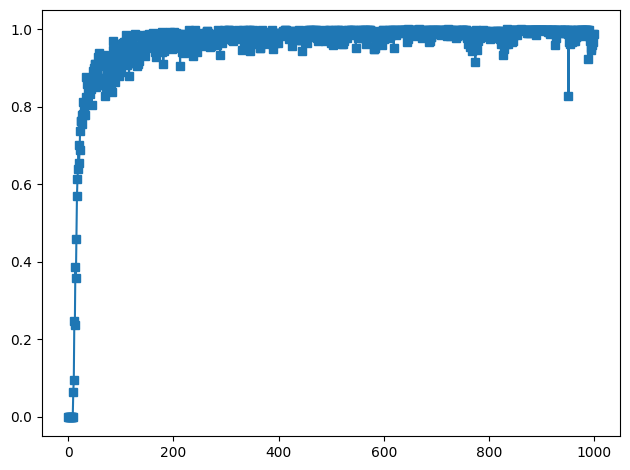

In [21]:

plt.plot(precision, 's-')
plt.tight_layout()
plt.show()